In [7]:
# load packages
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as ss

from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical, plot_subcortical
from enigmatoolbox.utils.useful import reorder_sctx


ext_scripts_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/scripts')
os.chdir(ext_scripts_dir)

from nm_utils import remove_bad_subjects, load_2d

code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)

# importing custom functions
import clinics_desc_functions as custom

sns.set(rc={'figure.facecolor':'white'})


# formatiing
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

# discrete colorscale for heatmap
# colorscale
pk = sns.color_palette("RdBu_r", 8)
dcsc = sns.color_palette("RdBu_r", 8)
dcsc[0] = pk[3]
dcsc[1] = pk[2]
dcsc[2] = pk[1]
dcsc[3] = pk[0]
dcsc[4] = pk[7]
dcsc[5] = pk[6]
dcsc[6] = pk[5]
dcsc[7] = pk[4]


In [8]:
import prepare_models_for_analysis

model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini()

# where things are
main_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO')
models_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/models/zscores_comparison_long')
os.makedirs(models_dir, exist_ok=True)
controls_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/models/control_stability_long')
patients_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/models/pretrained_long')
cdata_dir = ('/home/barbora/Documents/Projects/2021_06_AZV_ESO/data')
fsdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/fs_stats')
bdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/backup/fit_external_long')
pretrained_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts')
analysis_dir = os.path.join(main_dir, 'analyses', '01_PANSS')
images_dir = os.path.join(analysis_dir,'img')
os.makedirs(images_dir, exist_ok=True)


In [9]:
# load the data (generate them, if they don't exist)

if os.path.exists(os.path.join(analysis_dir,'data','pat_diff.txt')):
    v1_cont = pd.read_csv(os.path.join(analysis_dir,'data','v1_cont.txt'), sep=' ', index_col=0)
    v2_cont = pd.read_csv(os.path.join(analysis_dir,'data','v2_cont.txt'), sep=' ', index_col=0)
    v1_pat = pd.read_csv(os.path.join(analysis_dir,'data','v1_pat.txt'), sep=' ', index_col=0)
    v2_pat = pd.read_csv(os.path.join(analysis_dir,'data','v2_pat.txt'), sep=' ', index_col=0)
else:
    prepare_models_for_analysis.prepare_models_for_analysis(patients_dir, controls_dir, os.path.join(analysis_dir, 'data'))
    v1_cont = pd.read_csv(os.path.join(analysis_dir,'data','v1_cont.txt'), sep=' ', index_col=0)
    v2_cont = pd.read_csv(os.path.join(analysis_dir,'data','v2_cont.txt'), sep=' ', index_col=0)
    v1_pat = pd.read_csv(os.path.join(analysis_dir,'data','v1_pat.txt'), sep=' ', index_col=0)
    v2_pat = pd.read_csv(os.path.join(analysis_dir,'data','v2_pat.txt'), sep=' ', index_col=0)

In [10]:
# identify rows with missing clinical variables
clin_id = [i for i in v1_pat.columns if ('PANSS' in i) or ('GAF' in i)]

missing1 = list(dict.fromkeys(np.where(np.isnan(v1_pat[clin_id]))[0]))
missing2 = list(dict.fromkeys(np.where(np.isnan(v2_pat[clin_id]))[0]))
missing1.extend(missing2)
missing = list(dict.fromkeys(missing1))

In [11]:
# drop the rows
v1_pat = v1_pat.drop(v1_pat.iloc[missing].index)
v2_pat = v2_pat.drop(v2_pat.iloc[missing].index)
print(str(len(missing)),' patients were deleted')

3  patients were deleted


**1D analysis**
---------------

In [12]:
clin_id = [i for i in v1_pat if 'PANSS' in i ]
clin_id.append("GAF")

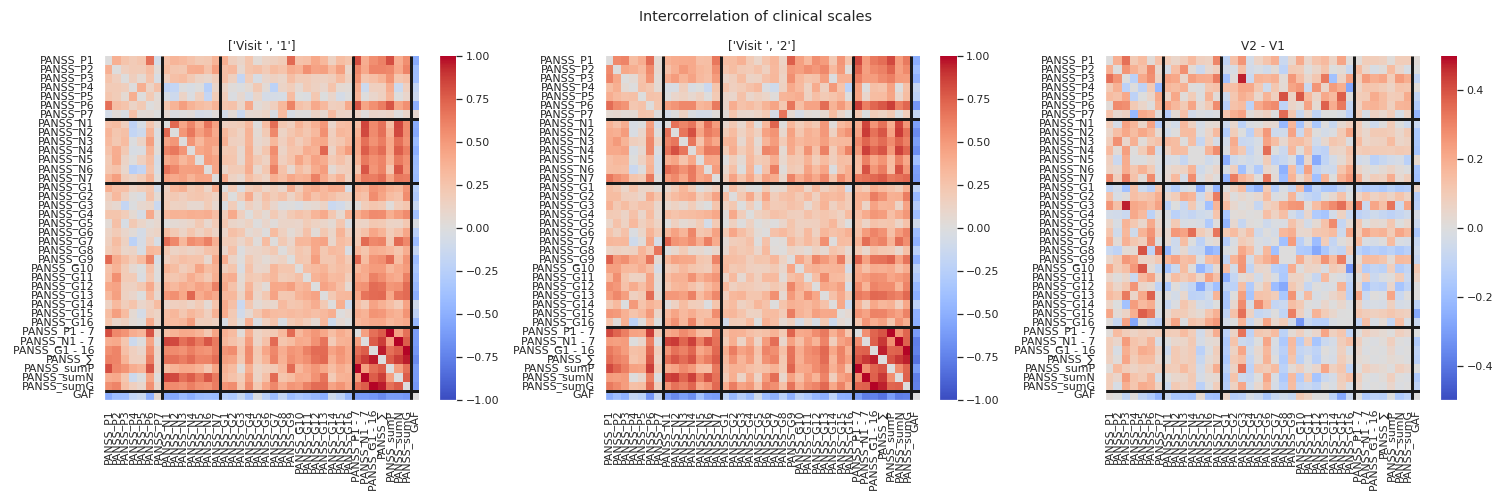

In [13]:
# Plot correlation matrices of clinical scales
import scipy.stats as ss 

fig,ax  = plt.subplots(1,3, figsize=(21,7))
for i in range(1,3):
    if i == 1:
        cmat = v1_pat
    else:
        cmat = v2_pat

    PANSS_spearman = ss.spearmanr(cmat[clin_id])

    sns.set(font_scale = 1)
    sns.heatmap(PANSS_spearman[0]-np.eye(PANSS_spearman[0].shape[0]), 
                center=False, 
                vmin = -1, 
                vmax = 1, 
                cmap='coolwarm', 
                annot=False,
                xticklabels=clin_id, yticklabels=clin_id,
                ax=ax[i-1])
    ax[i-1].hlines([7,14,PANSS_spearman[0].shape[0]-8, PANSS_spearman[0].shape[0]-1], *ax[i-1].get_xlim(), lw=3, color='k')
    ax[i-1].vlines([7,14,PANSS_spearman[0].shape[0]-8, PANSS_spearman[0].shape[0]-1], *ax[i-1].get_xlim(), lw=3, color='k')
    ax[i-1].set_title(['Visit ', str(i)])
    sns.despine()
    plt.tight_layout()
    plt.show

diff = ss.spearmanr(v2_pat[clin_id])[0] - ss.spearmanr(v1_pat[clin_id])[0]
sns.heatmap(diff, 
                center=False, 
                vmin = -.5, 
                vmax = .5, 
                cmap='coolwarm', 
                annot=False,
                xticklabels=clin_id, yticklabels=clin_id,
                ax=ax[2])
ax[2].set_title('V2 - V1')
ax[2].hlines([7,14,PANSS_spearman[0].shape[0]-8, PANSS_spearman[0].shape[0]-1], *ax[2].get_xlim(), lw=3, color='k')
ax[2].vlines([7,14,PANSS_spearman[0].shape[0]-8, PANSS_spearman[0].shape[0]-1], *ax[2].get_xlim(), lw=3, color='k')
fig.suptitle('Intercorrelation of clinical scales')
sns.despine()
plt.tight_layout()
plt.show
plt.savefig(os.path.join(images_dir,'clinics_intercorrelation'))




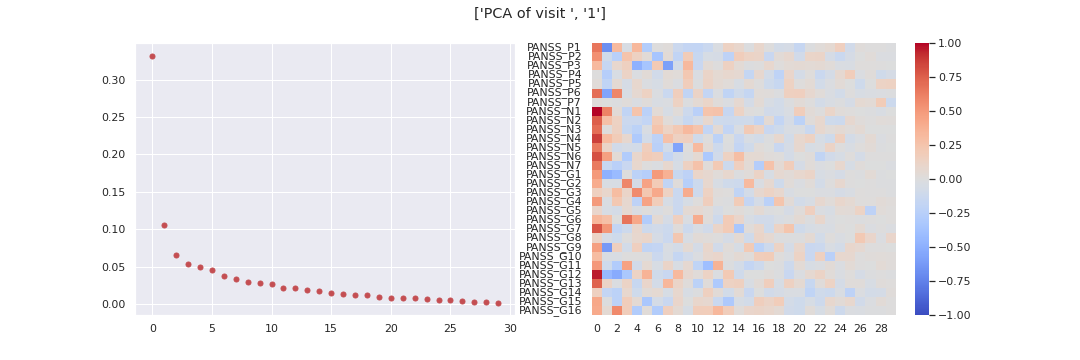

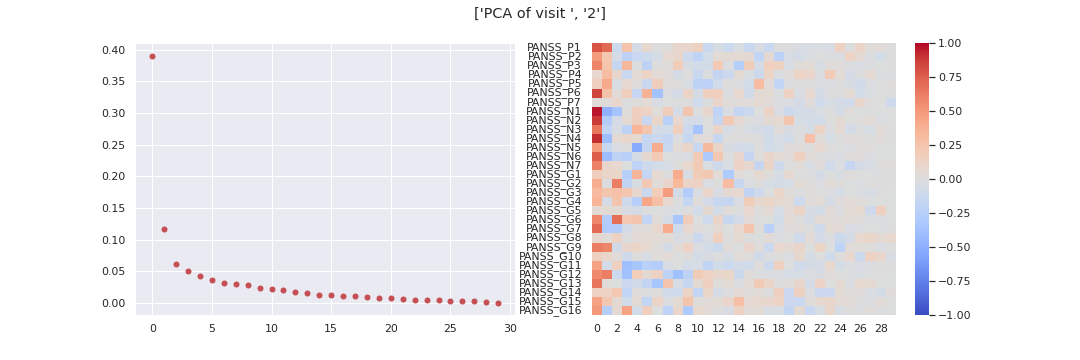

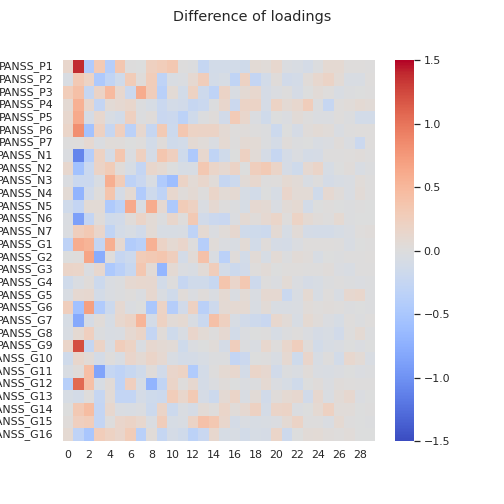

In [14]:
# PCA od PANSS scores
from sklearn.decomposition import PCA
for i in range(1,3):
    if i ==1:
        pcamat = v1_pat
    else:
        pcamat = v2_pat

    pca = PCA(n_components=min(pcamat[clin_id[:-8]].shape))
    pca.fit(pcamat[clin_id[:-8]])

    fig,ax  = plt.subplots(1,2, figsize=(15,5))
    ax[0].plot(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_, 'ro', markersize=5, linewidth = 3)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    sns.heatmap(loadings, yticklabels=clin_id[:-8], ax=ax[1], vmin=-1,vmax=1, cmap='coolwarm')
    fig.suptitle(['PCA of visit ', str(i)])
    plt.savefig(os.path.join(images_dir,'pca_PANSS_v'+str(i)))

pca1 = PCA(n_components=min(pcamat[clin_id[:-8]].shape))
pca1.fit(v1_pat[clin_id[:-8]])
pca2 = PCA(n_components=min(pcamat[clin_id[:-8]].shape))
pca2.fit(v2_pat[clin_id[:-8]])

fig,ax  = plt.subplots(1,1, figsize=(7,7))
sns.heatmap((pca2.components_.T * np.sqrt(pca2.explained_variance_) - pca1.components_.T * np.sqrt(pca1.explained_variance_)), yticklabels=clin_id[:-8], cmap='coolwarm', vmin=-1.5, vmax=1.5)
fig.suptitle('Difference of loadings')
plt.savefig(os.path.join(images_dir,'pca_PANSS_v2-v1'))

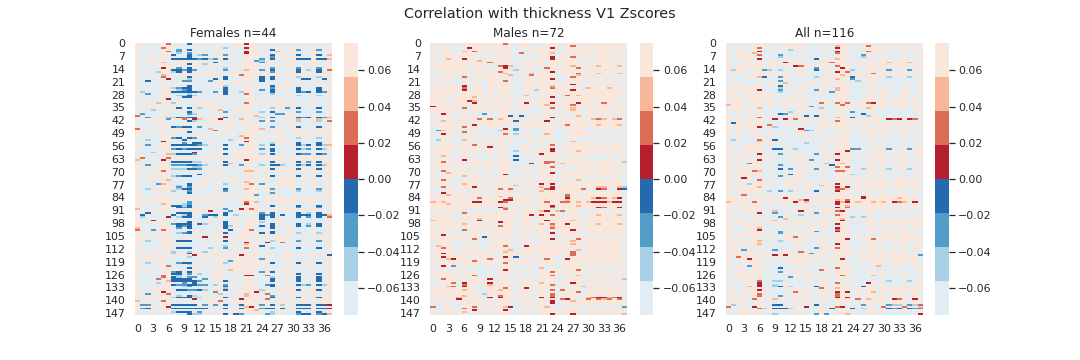

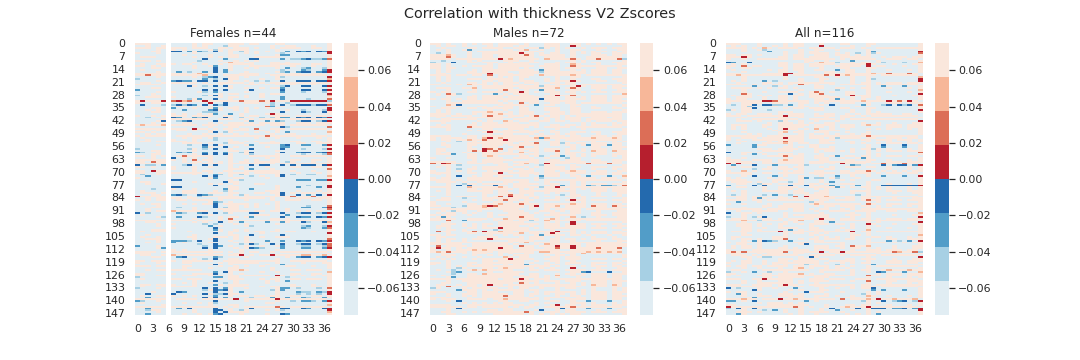

In [15]:
# Compute correlation of thickness zscores with clinical scales across sex
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

thick_id = [i for i in v1_pat.columns if 'thickness' in i]
f = v1_pat.index[v1_pat['sex']==0]
m = v1_pat.index[v1_pat['sex']==1]

for i in range(1,3):
    if i==1:
        cmat = v1_pat
    else:
        cmat = v2_pat

    spearman_f = custom.spearman_matrices(cmat[thick_id].loc[f], cmat[clin_id].loc[f])
    spearman_m = custom.spearman_matrices(cmat[thick_id].loc[m], cmat[clin_id].loc[m])
    spearman_all = custom.spearman_matrices(cmat[thick_id], cmat[clin_id])

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    sns.heatmap(spearman_f[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[0])
    ax[0].set_title('Females n='+str(len(f)))
    sns.heatmap(spearman_m[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[1])
    ax[1].set_title('Males n='+str(len(m)))
    sns.heatmap(spearman_all[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[2])
    ax[2].set_title('All n='+str(len(f)+len(m)))
    fig.suptitle('Correlation with thickness V'+str(i)+' Zscores')
    plt.savefig(os.path.join(images_dir, 'heatmaps_thickness_zscore_v'+str(i)))

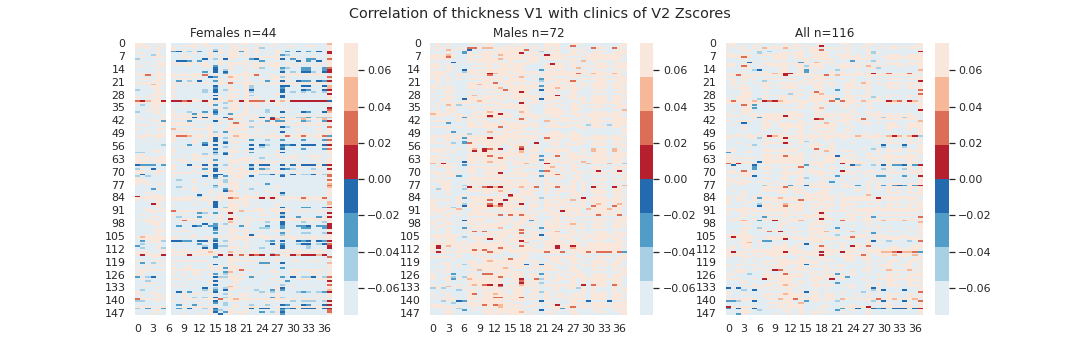

In [16]:
# Compute correlation of thickness zscores with clinical scales across sex
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

thick_id = [i for i in v1_pat.columns if 'thickness' in i]
f = v1_pat.index[v1_pat['sex']==0]
m = v1_pat.index[v1_pat['sex']==1]

spearman_f = custom.spearman_matrices(v1_pat[thick_id].loc[f], v2_pat[clin_id].loc[f])
spearman_m = custom.spearman_matrices(v1_pat[thick_id].loc[m], v2_pat[clin_id].loc[m])
spearman_all = custom.spearman_matrices(v1_pat[thick_id], v2_pat[clin_id])

fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.heatmap(spearman_f[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[0])
ax[0].set_title('Females n='+str(len(f)))
sns.heatmap(spearman_m[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[1])
ax[1].set_title('Males n='+str(len(m)))
sns.heatmap(spearman_all[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[2])
ax[2].set_title('All n='+str(len(f)+len(m)))
fig.suptitle('Correlation of thickness V1 with clinics of V2 Zscores')
plt.savefig(os.path.join(images_dir, 'heatmaps_thickness_zscore_v1_v2'))

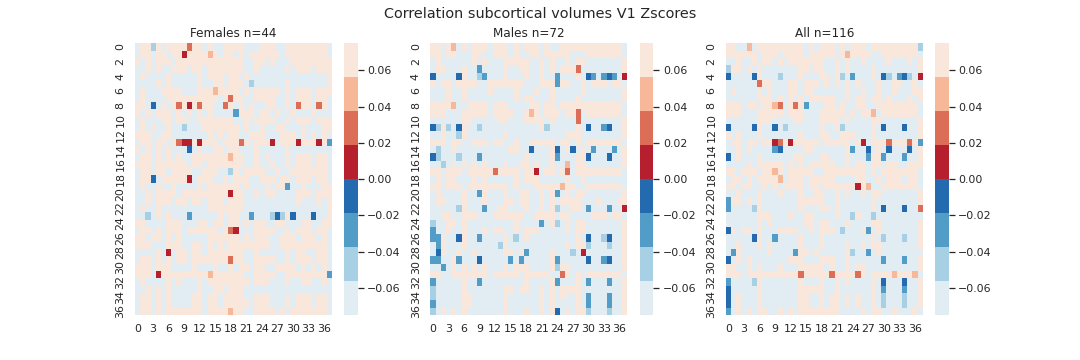

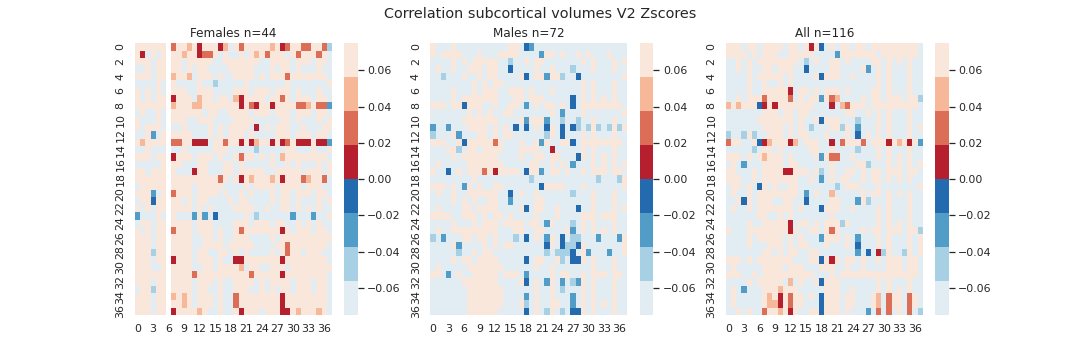

In [17]:
# Compute correlation of thickness with clinical scales across sex
sc_id = [i for i in idp_ids if 'thickness' not in i]
f = v1_pat.index[v1_pat['sex']==0]
m = v1_pat.index[v1_pat['sex']==1]

for i in range(1,3):
    if i==1:
        cmat = v1_pat
    else:
        cmat = v2_pat

    spearman_f = custom.spearman_matrices(cmat[sc_id].loc[f], cmat[clin_id].loc[f])
    spearman_m = custom.spearman_matrices(cmat[sc_id].loc[m], cmat[clin_id].loc[m])
    spearman_all = custom.spearman_matrices(cmat[sc_id], cmat[clin_id])

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    sns.heatmap(spearman_f[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[0])
    ax[0].set_title('Females n='+str(len(f)))
    sns.heatmap(spearman_m[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[1])
    ax[1].set_title('Males n='+str(len(m)))
    sns.heatmap(spearman_all[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[2])
    ax[2].set_title('All n='+str(len(f)+len(m)))
    fig.suptitle('Correlation subcortical volumes V'+str(i)+' Zscores')
    plt.savefig(os.path.join(images_dir, 'heatmaps_sc_volumes_zscore_v'+str(i)))

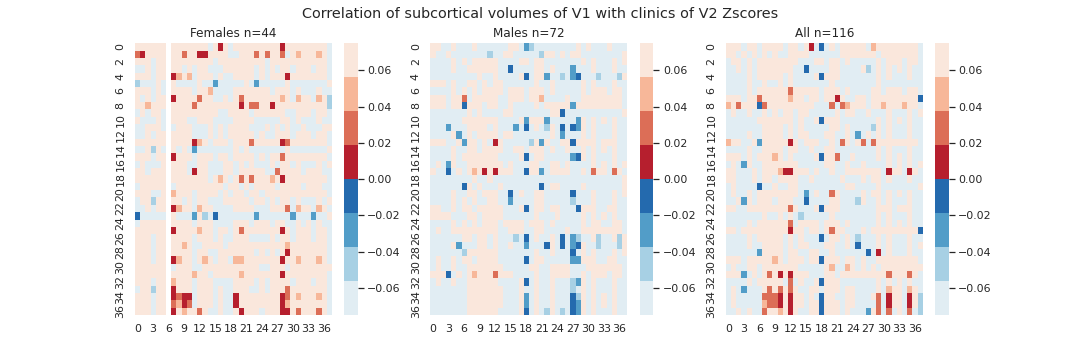

In [18]:
# Compute correlation of thickness with clinical scales across sex
sc_id = [i for i in idp_ids if 'thickness' not in i]
f = v1_pat.index[v1_pat['sex']==0]
m = v1_pat.index[v1_pat['sex']==1]

spearman_f = custom.spearman_matrices(v1_pat[sc_id].loc[f], v2_pat[clin_id].loc[f])
spearman_m = custom.spearman_matrices(v1_pat[sc_id].loc[m], v2_pat[clin_id].loc[m])
spearman_all = custom.spearman_matrices(v1_pat[sc_id], v2_pat[clin_id])

fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.heatmap(spearman_f[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[0])
ax[0].set_title('Females n='+str(len(f)))
sns.heatmap(spearman_m[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[1])
ax[1].set_title('Males n='+str(len(m)))
sns.heatmap(spearman_all[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[2])
ax[2].set_title('All n='+str(len(f)+len(m)))
fig.suptitle('Correlation of subcortical volumes of V1 with clinics of V2 Zscores')
plt.savefig(os.path.join(images_dir, 'heatmaps_sc_volumes_zscore_v1_v2'))

Comparison with pure thickness and volume instead of scores
-----------------------------------------------------------------

In [19]:
v1_pat_raw = pd.read_csv(os.path.join(analysis_dir,'data','v1_pat_raw.txt'), sep=' ', index_col=0)
v2_pat_raw = pd.read_csv(os.path.join(analysis_dir,'data','v2_pat_raw.txt'), sep=' ', index_col=0)

v1_pat_raw = pd.concat([v1_pat_raw,v1_pat[clin_id]],axis=1,join='inner')
v2_pat_raw = pd.concat([v2_pat_raw,v2_pat[clin_id]],axis=1,join='inner')

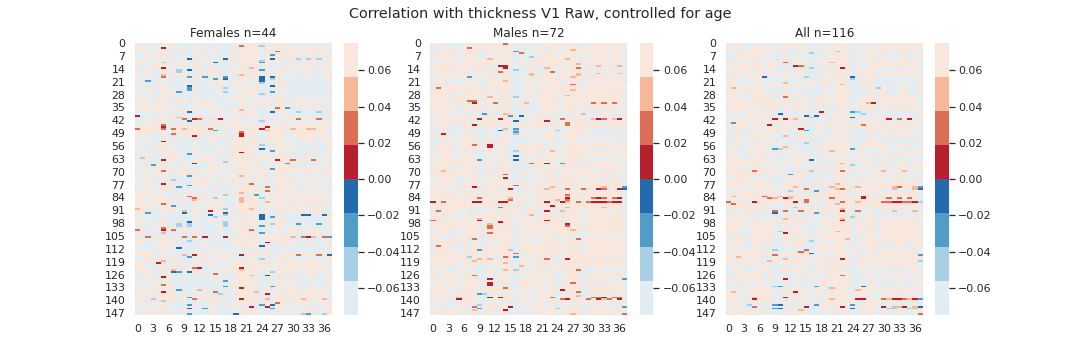

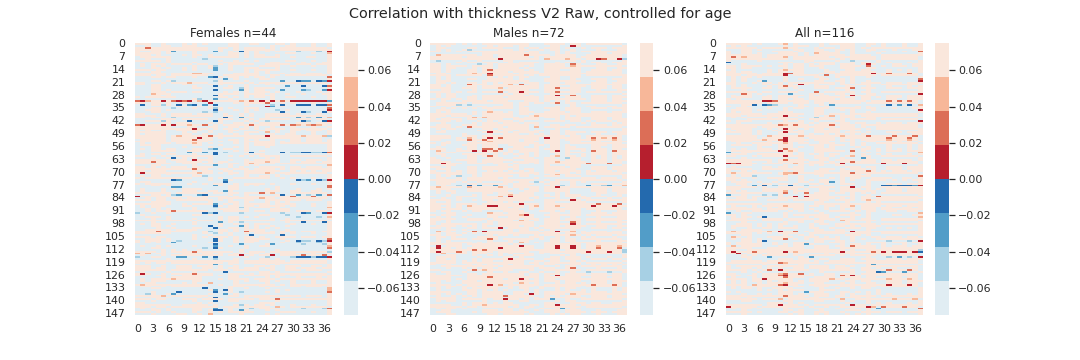

In [61]:
# Compute correlation of thickness with clinical scales across sex
thick_id = [i for i in v1_pat.columns if 'thickness' in i]
f = v1_pat_raw.index[v1_pat['sex']==0]
m = v1_pat_raw.index[v1_pat['sex']==1]

for i in range(1,3):
    if i==1:
        cmat = v1_pat_raw
    else:
        cmat = v2_pat_raw

    control_f = custom.control_for(cmat[thick_id].loc[f].to_numpy(), cmat['age'].loc[f].to_numpy().reshape(-1,1))
    control_fclin = custom.control_for(cmat[clin_id].loc[f].to_numpy(), cmat['age'].loc[f].to_numpy().reshape(-1,1))
    spearman_f = custom.spearman_matrices(control_f, control_fclin)
    
    control_m = custom.control_for(cmat[thick_id].loc[m].to_numpy(), cmat['age'].loc[m].to_numpy().reshape(-1,1))
    control_mclin = custom.control_for(cmat[clin_id].loc[m].to_numpy(), cmat['age'].loc[m].to_numpy().reshape(-1,1))
    spearman_m = custom.spearman_matrices(control_m, control_mclin)
    
    control_all = custom.control_for(cmat[thick_id].to_numpy(), cmat['age'].to_numpy().reshape(-1,1))
    control_aclin = custom.control_for(cmat[clin_id].to_numpy(), cmat['age'].to_numpy().reshape(-1,1))
    spearman_all = custom.spearman_matrices(control_all, control_aclin)

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    sns.heatmap(spearman_f[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[0])
    ax[0].set_title('Females n='+str(len(f)))
    sns.heatmap(spearman_m[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[1])
    ax[1].set_title('Males n='+str(len(m)))
    sns.heatmap(spearman_all[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[2])
    ax[2].set_title('All n='+str(len(f)+len(m)))
    fig.suptitle('Correlation with thickness V'+str(i)+' Raw, controlled for age')
    plt.savefig(os.path.join(images_dir, 'heatmaps_thickness_raw_controlled_age_v'+str(i)))




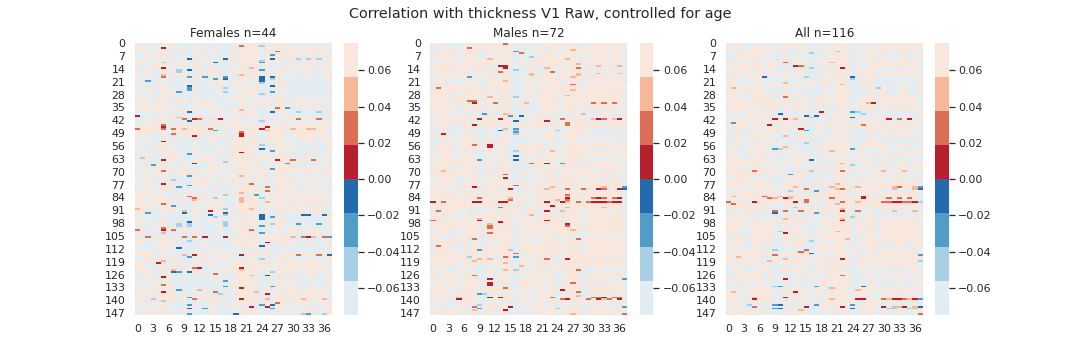

In [59]:
# Compute correlation of thickness with clinical scales across sex
thick_id = [i for i in v1_pat.columns if 'thickness' in i]
f = v1_pat_raw.index[v1_pat['sex']==0]
m = v1_pat_raw.index[v1_pat['sex']==1]

control_f = custom.control_for(v1_pat_raw[thick_id].loc[f].to_numpy(), cmat['age'].loc[f].to_numpy().reshape(-1,1))
control_fclin = custom.control_for(cmat[clin_id].loc[f].to_numpy(), cmat['age'].loc[f].to_numpy().reshape(-1,1))
spearman_f = custom.spearman_matrices(control_f, control_fclin)

control_m = custom.control_for(cmat[thick_id].loc[m].to_numpy(), cmat['age'].loc[m].to_numpy().reshape(-1,1))
control_mclin = custom.control_for(cmat[clin_id].loc[m].to_numpy(), cmat['age'].loc[m].to_numpy().reshape(-1,1))
spearman_m = custom.spearman_matrices(control_m, control_mclin)

control_all = custom.control_for(cmat[thick_id].to_numpy(), cmat['age'].to_numpy().reshape(-1,1))
control_aclin = custom.control_for(cmat[clin_id].to_numpy(), cmat['age'].to_numpy().reshape(-1,1))
spearman_all = custom.spearman_matrices(control_all, control_aclin)

fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.heatmap(spearman_f[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[0])
ax[0].set_title('Females n='+str(len(f)))
sns.heatmap(spearman_m[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[1])
ax[1].set_title('Males n='+str(len(m)))
sns.heatmap(spearman_all[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[2])
ax[2].set_title('All n='+str(len(f)+len(m)))
fig.suptitle('Correlation with thickness V'+str(i)+' Raw, controlled for age')
plt.savefig(os.path.join(images_dir, 'heatmaps_thickness_raw_controlled_age_v'+str(i)))




In [ ]:
def control_for(data, control):
    """
    intercept = ones(size(control,1),1)*mean(control);
    beta = (inv([intercept, control]' * [intercept, control]))*[intercept, control]'*data;
    controlled = data - [intercept, control]*beta;
    """
    if control.shape[0] < control.shape[1]:
        control = control.reshape(-1,1)
    
    intercept = np.ones([control.shape[0],1])*np.mean(control)
    X = np.column_stack((intercept, control))
    beta = (np.linalg.inv(X.T @ X)) @ X.T @ data
    controlled = data - X @ beta
    return(controlled)

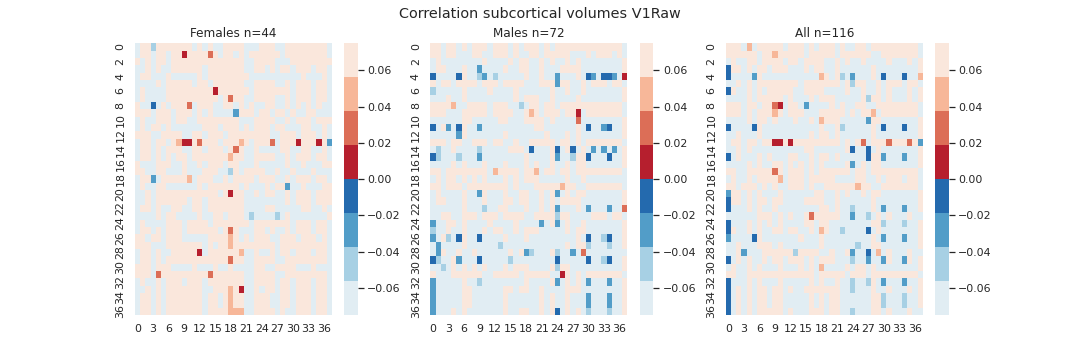

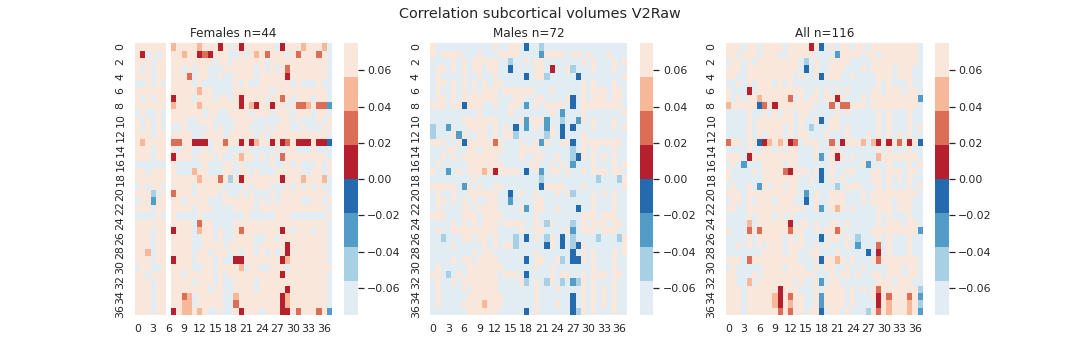

In [ ]:
# Compute correlation of thickness with clinical scales across sex
sc_id = [i for i in idp_ids if 'thickness' not in i]
f = v1_pat_raw.index[v1_pat['sex']==0]
m = v1_pat_raw.index[v1_pat['sex']==1]

for i in range(1,3):
    if i==1:
        cmat = v1_pat_raw
    else:
        cmat = v2_pat_raw

    spearman_f = spearman_matrices(cmat[sc_id].loc[f], cmat[clin_id].loc[f])
    spearman_m = spearman_matrices(cmat[sc_id].loc[m], cmat[clin_id].loc[m])
    spearman_all = spearman_matrices(cmat[sc_id], cmat[clin_id])

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    sns.heatmap(spearman_f[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[0])
    ax[0].set_title('Females n='+str(len(f)))
    sns.heatmap(spearman_m[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[1])
    ax[1].set_title('Males n='+str(len(m)))
    sns.heatmap(spearman_all[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[2])
    ax[2].set_title('All n='+str(len(f)+len(m)))
    fig.suptitle('Correlation subcortical volumes V'+str(i)+'Raw')
    plt.savefig(os.path.join(images_dir, 'heatmaps_sc_volumes_raw_v'+str(i)))

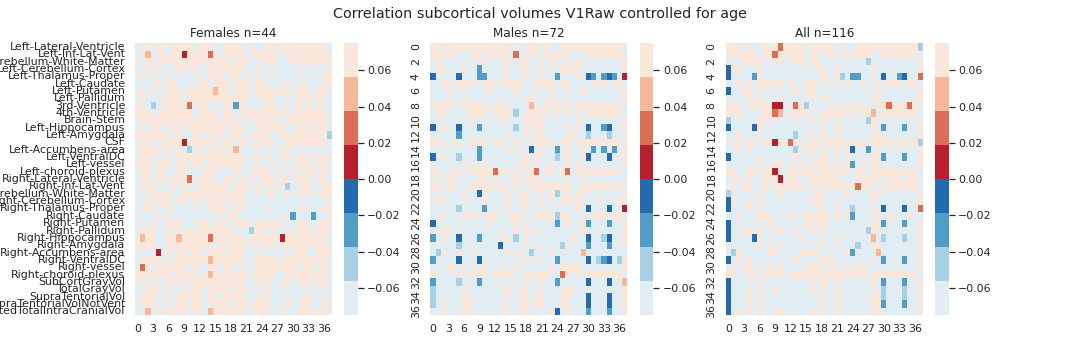

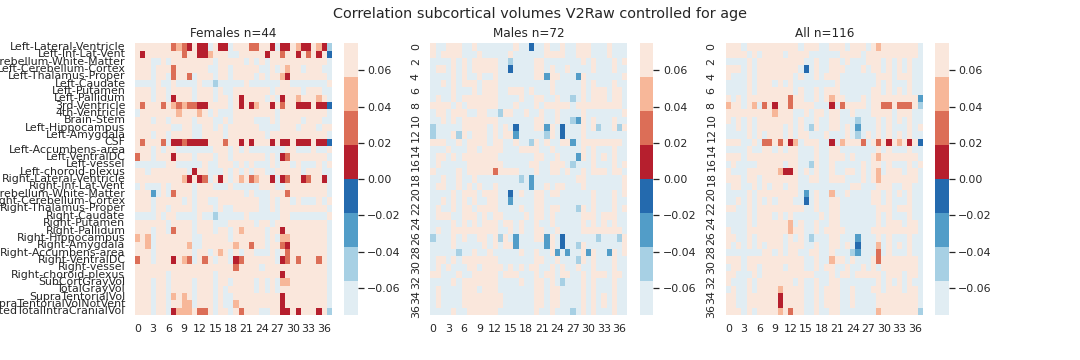

In [ ]:
# Compute correlation of thickness with clinical scales across sex
sc_id = [i for i in idp_ids if 'thickness' not in i]
f = v1_pat_raw.index[v1_pat['sex']==0]
m = v1_pat_raw.index[v1_pat['sex']==1]

for i in range(1,3):
    if i==1:
        cmat = v1_pat_raw
    else:
        cmat = v2_pat_raw

    control_f = control_for(cmat[sc_id].loc[f].to_numpy(), cmat['age'].loc[f].to_numpy().reshape(-1,1))
    control_fclin = control_for(cmat[clin_id].loc[f].to_numpy(), cmat['age'].loc[f].to_numpy().reshape(-1,1))
    spearman_f = spearman_matrices(control_f, control_fclin)
    
    control_m = control_for(cmat[sc_id].loc[m].to_numpy(), cmat['age'].loc[m].to_numpy().reshape(-1,1))
    control_mclin = control_for(cmat[clin_id].loc[m].to_numpy(), cmat['age'].loc[m].to_numpy().reshape(-1,1))
    spearman_m = spearman_matrices(control_m, control_mclin)
    
    control_a = control_for(cmat[sc_id].to_numpy(), cmat['age'].to_numpy().reshape(-1,1))
    control_aclin = control_for(cmat[clin_id].to_numpy(), cmat['age'].to_numpy().reshape(-1,1))
    spearman_all = spearman_matrices(control_a, control_aclin)

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    sns.heatmap(spearman_f[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[0], yticklabels=sc_id)
    ax[0].set_title('Females n='+str(len(f)))
    sns.heatmap(spearman_m[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[1])
    ax[1].set_title('Males n='+str(len(m)))
    sns.heatmap(spearman_all[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[2])
    ax[2].set_title('All n='+str(len(f)+len(m)))
    fig.suptitle('Correlation subcortical volumes V'+str(i)+'Raw controlled for age')
    plt.savefig(os.path.join(images_dir, 'heatmaps_sc_volumes_raw_controlled_age_v'+str(i)))

**Investigation of the weird blue columns in females**
------------------------------------------------------------

In [21]:
v1_pat[clin_id+['sex']].groupby('sex').agg(['mean', 'std']).transpose()

# fig, ax = plt.subplots(1,2,figsize=(15,5))
# sns.boxplot(data = v1_pat[clin_id[0:30]].loc[v1_pat['sex']==0], ax=ax[0])
# ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 90)
# sns.boxplot(data = v1_pat[clin_id[0:30]].loc[v1_pat['sex']==1], ax=ax[1])
# ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 90)

sex                      0          1
PANSS_P1   mean   2.295455   2.000000
           std    1.211947   1.162804
PANSS_P2   mean   1.750000   1.680556
           std    0.991241   0.901117
PANSS_P3   mean   1.545455   1.472222
...                    ...        ...
PANSS_sumN std    6.107909   5.671342
PANSS_sumG mean  29.545455  27.583333
           std    8.428784   6.761011
GAF        mean  66.113636  66.888889
           std   14.304359  15.822569

[76 rows x 2 columns]

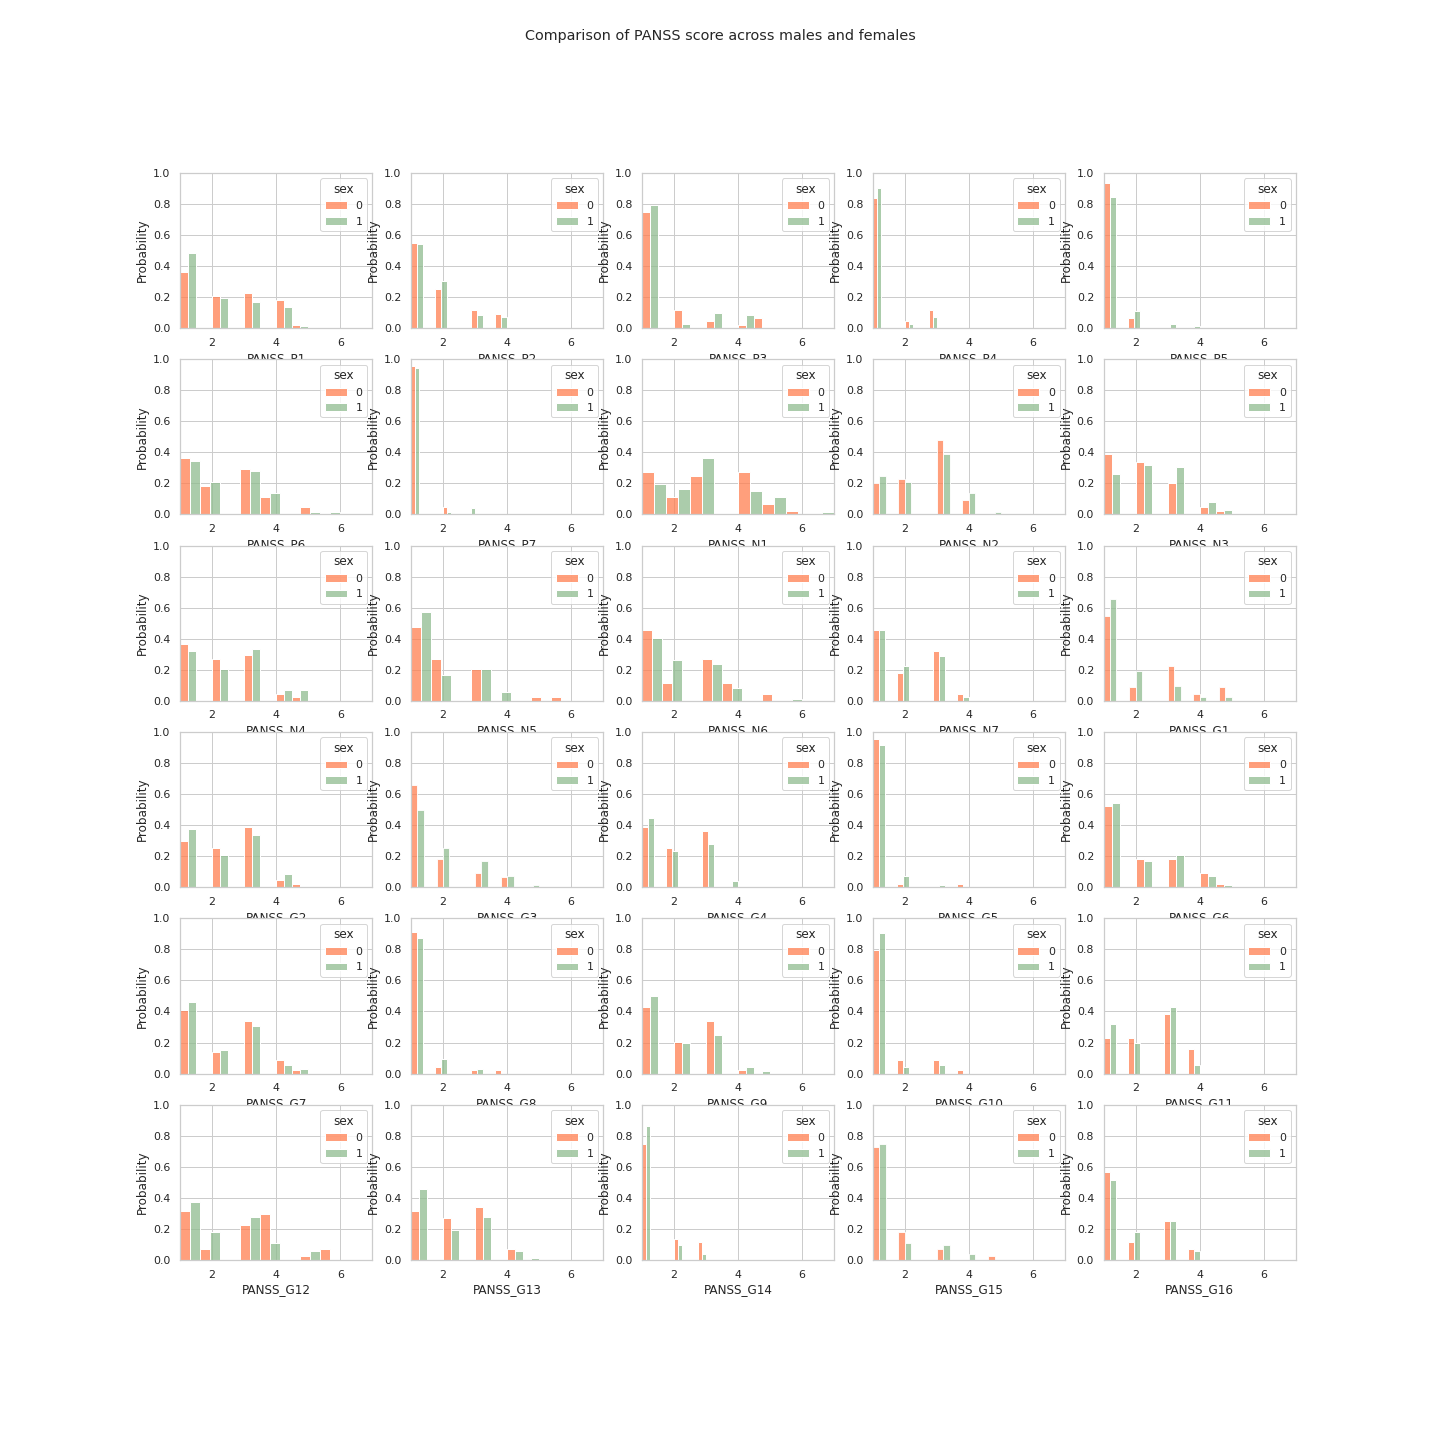

In [26]:
# PANSS across sex
FM_colors = ["coral", "darkseagreen"]
fm_palette = sns.set_palette(sns.color_palette(FM_colors))

fig, ax = plt.subplots(6,5, figsize=(20,20))

for iplot in range(30):    
    x = int(np.floor(iplot/5))
    y = np.mod(iplot,5)
    sns.histplot(ax = ax[x,y], data = v1_pat, x = clin_id[iplot], hue='sex', stat='probability', common_norm = False, multiple='dodge', palette=fm_palette)
    ax[x,y].set_xlim(1,7)
    ax[x,y].set_ylim(0,1)

fig.suptitle('Comparison of PANSS score across males and females')
plt.savefig(os.path.join(images_dir, 'PANSS_across_sex'),  bbox_inches='tight')
    

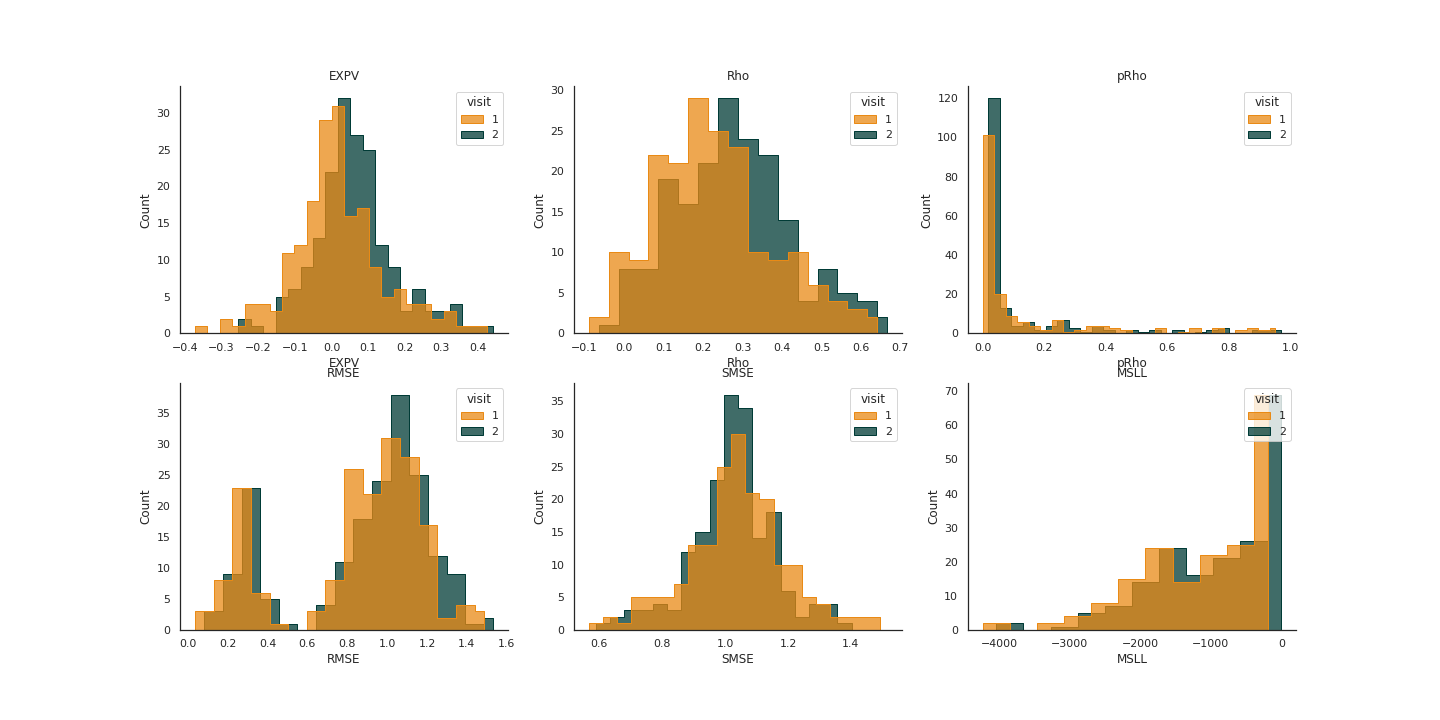

In [62]:
# Concatenate and plot quality measures of fitted models
v1_qm,quality_measures = idp_concat_quality('/home/barbora/Documents/Projects/Normative_Models/ESO/models/pretrained_long/V1', idp_ids)
v1_qm['visit'] = '1'
v2_qm,quality_measures = idp_concat_quality('/home/barbora/Documents/Projects/Normative_Models/ESO/models/pretrained_long/V2', idp_ids)
v2_qm['visit'] = '2'

qm = pd.concat([v1_qm, v2_qm]).reset_index()

visit_colors = ["#E98A15", "#003B36"]


sns.set_style("white")
fig, ax = plt.subplots(2,3, figsize=(20,10))

for iplot in range(6):
    x = int(np.floor(iplot/3))
    y = np.mod(iplot,3)
    sns.histplot(data = qm, x=quality_measures[iplot], hue='visit', element='step', ax=ax[x,y], palette=sns.color_palette(visit_colors), multiple='dodge')
    ax[x,y].set_title(quality_measures[iplot])

sns.despine()
plt.savefig(os.path.join('/home/barbora/Documents/Projects/Normative_Models/ESO/models/pretrained_long', 'quality_measures'),  bbox_inches='tight')

In [10]:
pat_clin_diff = v2_pat_clin[[col for col in v2_pat_clin.columns if "PANSS_sum" in col]] - v1_pat_clin[[col for col in v1_pat_clin.columns if "PANSS_sum" in col]]
pat_clin_diff["PANSS_sum_all"] = v2_pat_clin[[col for col in v2_pat_clin.columns if "PANSS_sum" in col]].sum(axis=1) - v1_pat_clin[[col for col in v1_pat_clin.columns if "PANSS_sum" in col]].sum(axis=1)
pat_clin_diff = pat_clin_diff.add_prefix("v2-v1_")

NameError: name 'v2_pat_clin' is not defined

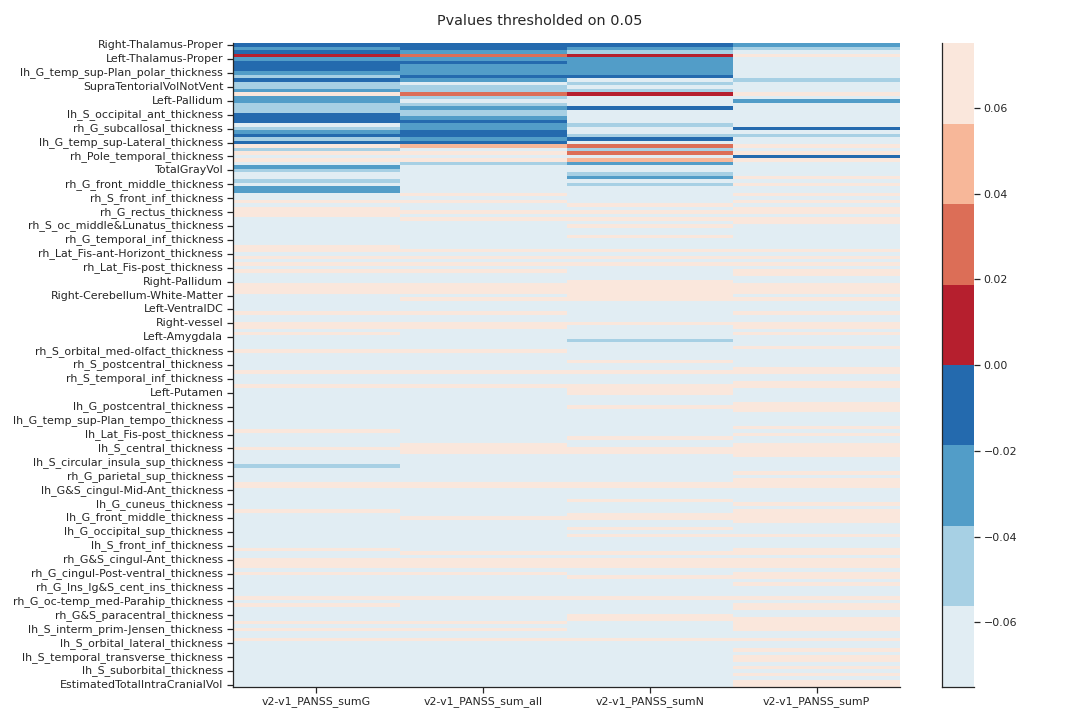

In [ ]:
# Compute correlation of 
spearman_r = ss.spearmanr(pat_diff, pat_clin_diff)
spearman_r = np.array([spearman_r[0][:-pat_clin_diff.shape[1],-pat_clin_diff.shape[1]:], spearman_r[1][:-pat_clin_diff.shape[1],-pat_clin_diff.shape[1]:]])
df_spearman_r = pd.DataFrame(spearman_r[0], index=pat_diff.columns, columns=["v2-v1_PANSS_sumP","v2-v1_PANSS_sumN","v2-v1_PANSS_sumG", "v2-v1_PANSS_sum_all"])

spearman_r_sorted = reordered_heatmap(pd.DataFrame(spearman_r[1], index=pat_diff.columns, columns=["v2-v1_PANSS_sumP","v2-v1_PANSS_sumN","v2-v1_PANSS_sumG", "v2-v1_PANSS_sum_all"]),
                    range = pd.DataFrame(spearman_r[0]))

In [ ]:
# plot GM
mapping_r, view_r = custom.prepare_destrieux_plotting(pd.DataFrame(df_spearman_r['v2-v1_PANSS_sum_all']), 'r')

NameError: name 'fsaverage' is not defined

In [11]:
# plot GM
mapping_l, view_l = prepare_destrieux_plotting(pd.DataFrame(df_spearman_r['PANSS_sum_all']), 'l')

NameError: name 'prepare_destrieux_plotting' is not defined

In [ ]:
view_l

In [ ]:
# Plot subcortical structures 
data_short, data_mapped = fs_map_subcortical(pd.DataFrame(df_spearman_r['v2-v1_PANSS_sum_all']))
enigmatoolbox.plotting.surface_plotting.plot_subcortical(pk, size=(800,400), 
                                                        cmap='RdBu_r', color_bar=True,
                                                        color_range=(-0.5,0.5))

In [223]:
v2_cont.shape

(70, 193)